In [1]:
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

import matplotlib.ticker as mtick

import torch
from torch.autograd import Variable

modulo = 101

In [2]:
def f_t(x):
    c = np.random.choice([1010,-10], p=[0.01,0.99])
    return x*float(c)

def f_t_mod(x,t):
    if(t%modulo == 1):
        c=1010
    else:
        c=(-10)
    return x*float(c)

# Beale's function
f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2


In [3]:
def regret(loss_sum,min_loss_sum,t):
    return (loss_sum - min_loss_sum)/t
    

In [4]:
def adjust_learning_rate(optimizer,lr,t):
    new_lr = lr/np.sqrt(t)
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

0.5
0.5


<Figure size 432x288 with 0 Axes>

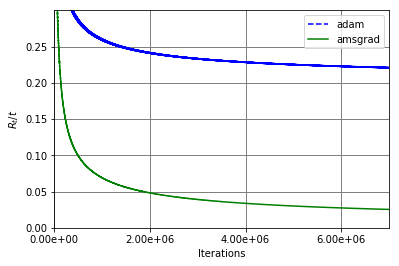

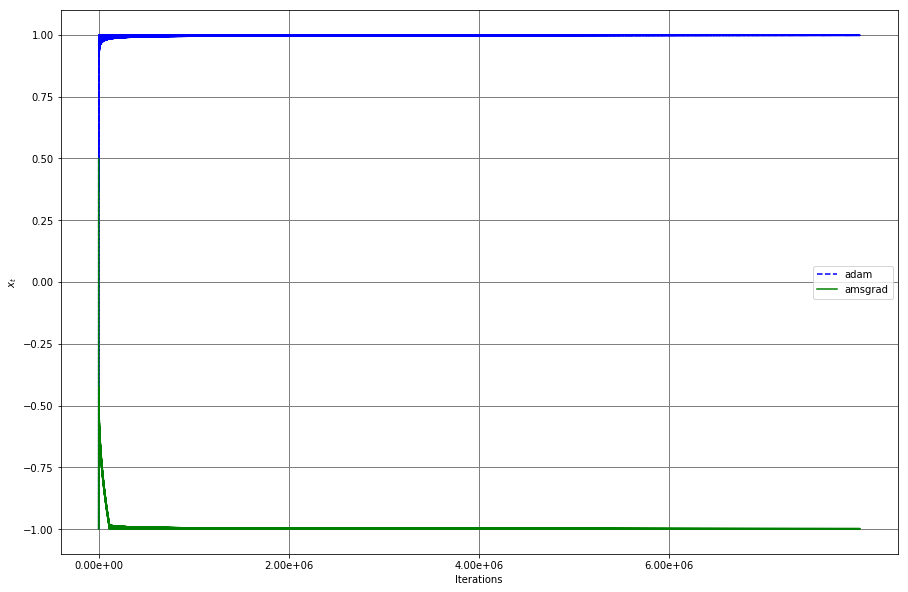

ansgrad_x:  -0.9983012080192566
adam_x:  1.0

 regret amsgrad:  0.02368329049357772

 regret adam:  0.21932028409890061


0

In [5]:
from amsgrad import Amsgrad
from adam import Adam

iters = int(8e6)
# iters = int(1e4)

my_lr = 1
beta = (0.9,0.99)

t=1

total_loss_amsgrad = 0
total_min_loss_amsgrad = 0

total_loss_adam = 0
total_min_loss_adam = 0

x_var_adam = 0
x_var_amsgrad = 0

# n = np.random.rand(1,1)
n = 0.5

x_var_adam = Variable(torch.FloatTensor([n]), requires_grad=True)
adam = torch.optim.Adam([x_var_adam], betas=beta, lr=my_lr)

x_var_amsgrad = Variable(torch.FloatTensor([n]), requires_grad=True)
amsgrad = Amsgrad([x_var_amsgrad], betas=beta , lr=my_lr)
# amsgrad = Adam([x_var_amsgrad], betas=beta, lr=my_lr, amsgrad=True)

print(x_var_amsgrad.data[0])
print(x_var_adam.data[0])


x_var_adam_hist = [x_var_adam.data[0]]
x_var_amsgrad_hist = [x_var_amsgrad.data[0]]


regret_adam_hist=[]
regret_amsgrad_hist=[]

def closure_adam(): 
    c = 1010 if t%modulo == 1 else -10
    
    adam.zero_grad()
    loss = f_t_mod(x_var_adam,t)
    loss.backward()
    
    global total_loss_adam
    total_loss_adam += loss.data[0]
    
    global total_min_loss_adam
    
    #minimum point is at -1
    total_min_loss_adam += -1*c
    
    return loss

def closure_amsgrad(): 
    
    c = 1010 if t%modulo == 1 else -10
    
    amsgrad.zero_grad()
    loss = f_t_mod(x_var_amsgrad,t)
    loss.backward()
    
    global total_loss_amsgrad
    total_loss_amsgrad += loss.data[0]
    
    global total_min_loss_amsgrad
    
    #minimum point is at -1
    total_min_loss_amsgrad += -1*c
    
    return loss

t=1
for i in range(iters):
    
    #zero the gradients
    amsgrad.zero_grad()
    adam.zero_grad()
    
    #Perform an optimization step
    adam.step(closure_adam)
    amsgrad.step(closure_amsgrad)
    
    #Clamp the variables between -1 and 1
    x_var_adam.data = x_var_adam.data.clamp(-1,1)
    x_var_amsgrad.data = x_var_amsgrad.data.clamp(-1,1)
    
    #Calculate the regret
    adam_regret = regret(total_loss_adam,total_min_loss_adam,t)
    ams_regret = regret(total_loss_amsgrad,total_min_loss_amsgrad,t)
    
    #Store regret
    regret_adam_hist.append(adam_regret)
    regret_amsgrad_hist.append(ams_regret)

    #Store the x_t values
    x_var_adam_hist.append(x_var_adam.data[0])
    x_var_amsgrad_hist.append(x_var_amsgrad.data[0])
    
    #Adjust learning rate by dividing by sqrt(t)
    adjust_learning_rate(adam,my_lr,t)
    adjust_learning_rate(amsgrad,my_lr,t)
    t+=1
    


# regret_adam = np.ndarray(x,regret_adam_hist)
# regret_amsgrad = np.ndarray(x,regret_amsgrad_hist)


# %matplotlib notebook

In [49]:

xsteps = [0,2e6,4e6,6e6]
regret_max = 0.3


x = list(range(0,iters))
plt.clf()
fig1, ax1 = plt.subplots()

plt.xlabel("Iterations")
plt.ylabel("$R_t/t$")
ax1.plot(x, regret_adam_hist, label="adam", c='b', ls='--')
ax1.plot(x, regret_amsgrad_hist,label="amsgrad",c='g')
ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
ax1.set_xticks(xsteps)
ax1.set_yticks(np.arange(0, regret_max, step=regret_max/6))
ax1.set_ylim(0,0.3)
ax1.set_xlim(0,7e6)
# ax1.xscale('log')
ax1.legend(loc='best')
plt.rcParams["figure.figsize"] = (15,10)
ax1.grid(color='gray', linewidth=1)
# plt.axis([0.0000001, 5, 1, 7])
plt.show()

fig1, ax1 = plt.subplots()
x = list(range(0,iters+1))
plt.plot(x, x_var_adam_hist, label="adam", c='b', ls='--')
plt.plot(x, x_var_amsgrad_hist, label="amsgrad", c='g')
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)
plt.xlabel("Iterations")
plt.ylabel("$x_t$")
# ax1.xscale('log')
ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.rcParams["figure.figsize"] = (15,10)
ax1.grid(color='gray', linewidth=1)
ax1.legend(loc='best')
ax1.set_xticks(xsteps)
plt.show()

print("ansgrad_x: ", x_var_amsgrad.data[0])
print("adam_x: ", x_var_adam.data[0])

print("\n regret amsgrad: ", regret_amsgrad_hist[-1])
print("\n regret adam: ", regret_adam_hist[-1])

import os
os.system('spd-say "your program has finished"')

ValueError: x and y must have same first dimension, but have shapes (10000000,) and (8000000,)

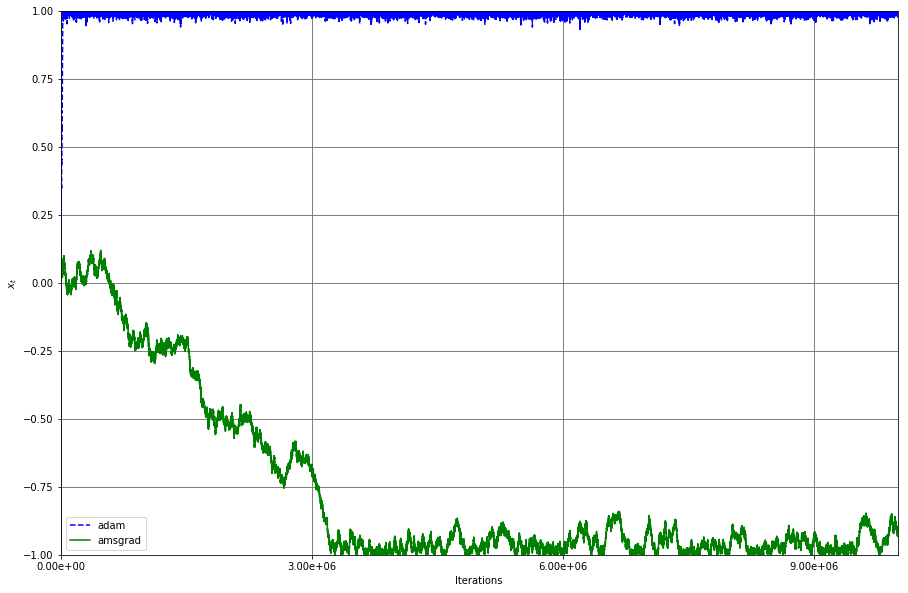

-0.9287340641021729
0.9950363039970398


0

In [6]:
iters = int(1e7)
# iters=int(1e5)

my_lr = 5e-4 # 1e-4 was very good - slightly slow


t=1
x_var_adam = Variable(torch.FloatTensor([0]), requires_grad=True)
adam = torch.optim.Adam([x_var_adam], betas=beta, lr=my_lr)

x_var_amsgrad = Variable(torch.FloatTensor([0]), requires_grad=True)
amsgrad = Amsgrad([x_var_amsgrad], lr=my_lr, betas=beta)

x_var_adam_hist = [x_var_adam.data[0]]
x_var_amsgrad_hist = [x_var_amsgrad.data[0]]


def closure_adam(): 
    c = 1010 if t%modulo == 1 else -10
    
    adam.zero_grad()
    loss = f_t(x_var_adam)
    loss.backward()
    
    global total_loss_adam
    total_loss_adam += loss.data[0]
    
    global total_min_loss_adam
    
    #minimum point is at -1
    total_min_loss_adam += -1*c
    
    return loss

def closure_amsgrad(): 
    
    c = 1010 if t%modulo == 1 else -10
    
    amsgrad.zero_grad()
    loss = f_t(x_var_amsgrad)
    loss.backward()
    
    global total_loss_amsgrad
    total_loss_amsgrad += loss.data[0]
    
    global total_min_loss_amsgrad
    
    #minimum point is at -1
    total_min_loss_amsgrad += -1*c
    
    return loss



t=1
for i in range(iters):
    amsgrad.zero_grad()
    adam.zero_grad()
    
    adam.step(closure_adam)
    amsgrad.step(closure_amsgrad)
    
    x_var_adam.data = x_var_adam.data.clamp(-1,1)
    x_var_amsgrad.data = x_var_amsgrad.data.clamp(-1,1)
    
    x_var_adam_hist.append(x_var_adam.data[0])
    x_var_amsgrad_hist.append(x_var_amsgrad.data[0])
    
    #Adjust learning rate by dividing by sqrt(t)
#     adjust_learning_rate(adam,my_lr,t)
#     adjust_learning_rate(amsgrad,my_lr,t)
    
    t+=1
t=1
    
    
# xsteps = [0, 3e6, 6e6, 9e6]
# fig1, ax1 = plt.subplots()
# x = list(range(0,iters+1))
# plt.plot(x, x_var_adam_hist, label="adam", c='b', ls='--')
# plt.plot(x, x_var_amsgrad_hist, label="amsgrad", c='g')
# plt.xlabel("Iterations")
# plt.ylabel("$x_t$")
# ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
# plt.rcParams["figure.figsize"] = (15,10)
# plt.axis([0, iters, -1, 1])
# ax1.grid(color='gray', linewidth=1)
# ax1.legend(loc='best')
# ax1.set_xticks(xsteps)
# plt.show()
    

# print(x_var_amsgrad.data[0])
# print(x_var_adam.data[0])


# import os
# os.system('spd-say "your program has finished"')


    

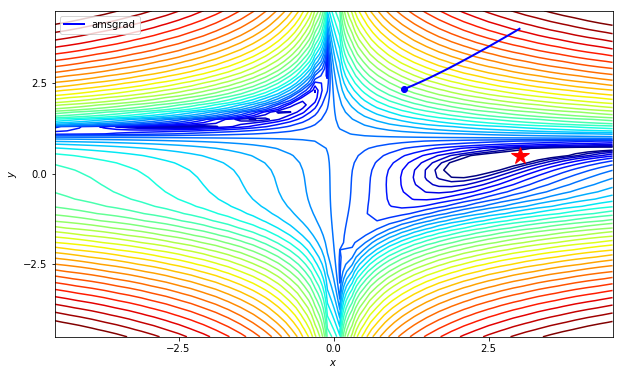

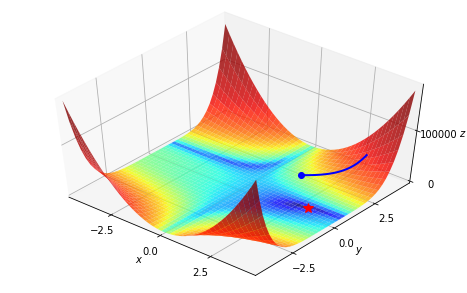

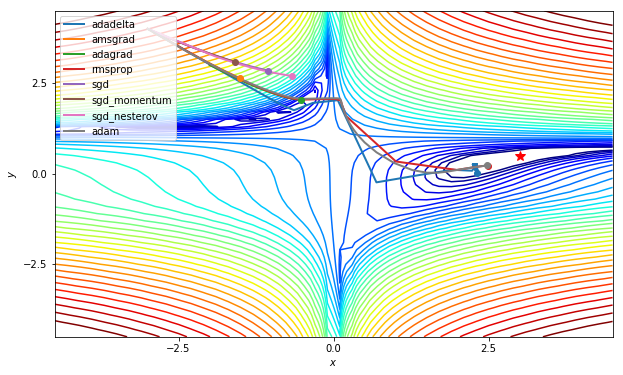

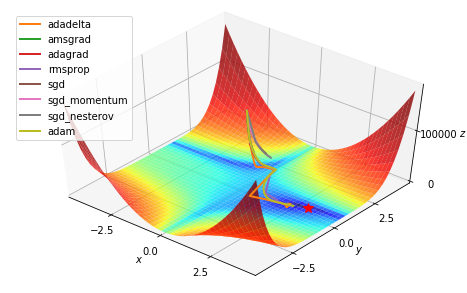

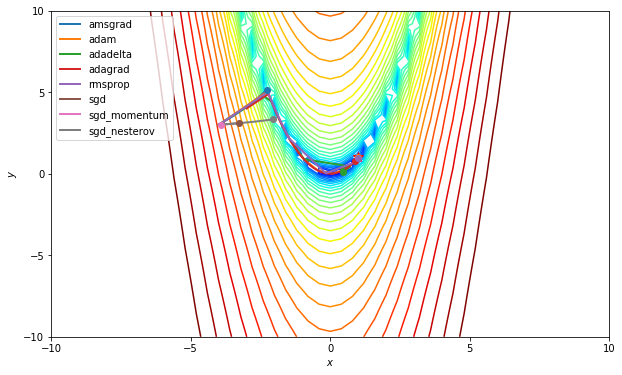

<Figure size 576x360 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

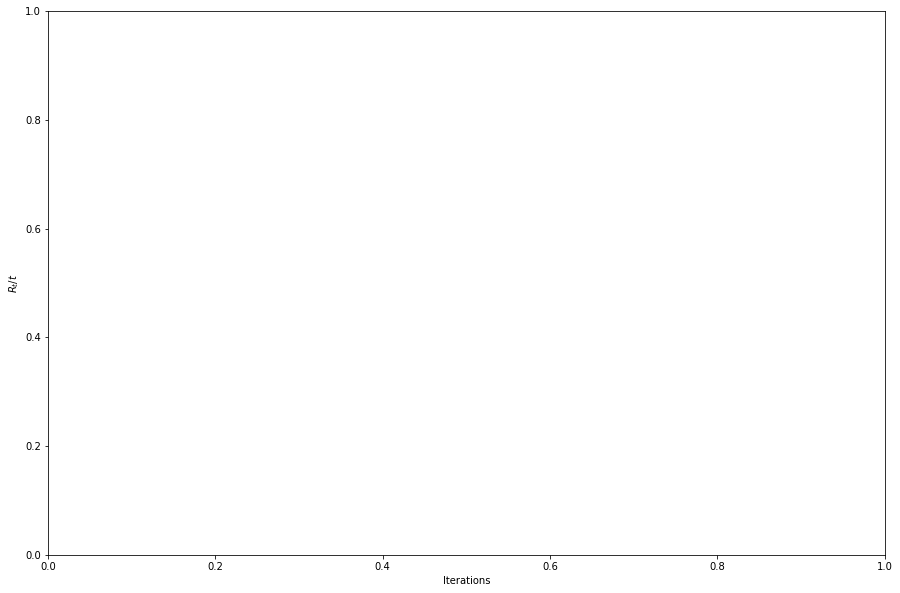

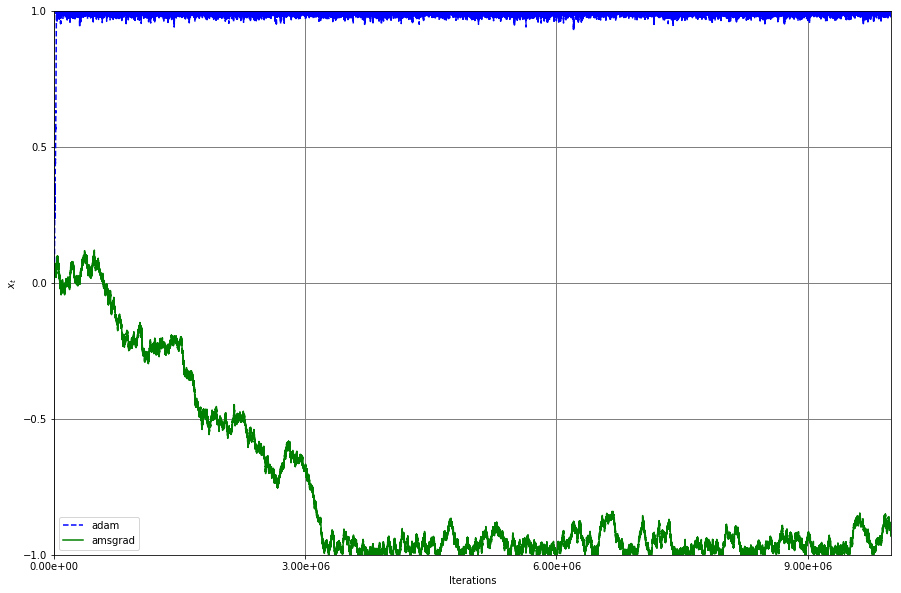

-0.9287340641021729
0.9950363039970398


0

In [50]:
xsteps = [0, 3e6, 6e6, 9e6]
fig1, ax1 = plt.subplots()
x = list(range(0,iters+1))
plt.plot(x, x_var_adam_hist, label="adam", c='b', ls='--')
plt.plot(x, x_var_amsgrad_hist, label="amsgrad", c='g')
plt.xlabel("Iterations")
plt.ylabel("$x_t$")
ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
plt.rcParams["figure.figsize"] = (15,10)
plt.axis([0, iters, -1, 1])
ax1.grid(color='gray', linewidth=1)
ax1.legend(loc='best')
plt.rc('xtick', labelsize=40)
plt.rc('ytick', labelsize=40)
ax1.set_xticks(xsteps)
plt.show()
    

print(x_var_amsgrad.data[0])
print(x_var_adam.data[0])


import os
os.system('spd-say "your program has finished"')


# Everything Below here was just for visualizing the algorithms for the presentation

In [7]:
# Beale's function
f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

def getMinima(x,y):
    minima = np.array([float(x),float(y)])
    minima = minima.reshape(-1,1)
    return minima


x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = f(x,y)

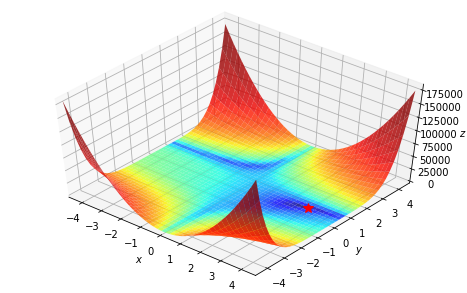

In [8]:
minima = getMinima(3,0.5)
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima, f(*minima), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

In [9]:
x0 = np.array([3., 4.])

In [10]:
w_adam = Variable(torch.FloatTensor(x0), requires_grad=True)
adam = torch.optim.Adam([w_adam], lr = 1e-3)

In [11]:
def var_ft(x,y):
    c = np.random.choice([1010,-10], p=[0.01,0.99])
    c = np.array([float(c)])
    c = Variable(torch.FloatTensor(c))
    return (c*x + c*y)

def beales_var(var):
    x = var[0]
    y = var[1]
    
    return ((1.5 - x + x*y).pow(2) + (2.25 - x + (x*y).pow(2)).pow(2) + (2.625 - x + (x*y).pow(3)).pow(2))
#     return var_ft(x,y)

In [12]:
def get_parameterized_closure(optimizer,f,w):
    def closure(): 
        optimizer.zero_grad()
        loss = f(w)
        loss.backward()
        return loss
    return closure

In [13]:
def optimize(optim, f, w, steps, length):
    closure = get_parameterized_closure(optim,f,w)
    path = np.ndarray(shape=(steps,2),dtype=float)
    for step in range(steps):
        optim.step(closure)
        path[step][0] = w[0].data[0]
        path[step][1] = w[1].data[0]
    result = np.ndarray(shape=(length,2),dtype=float)
    idx = 0
    for n in np.linspace(0,steps-1,num=length, dtype=int):
        result[idx] = path[n]
        idx += 1
    return result

In [14]:
path = optimize(adam,beales_var,w_adam,10000, 100).T

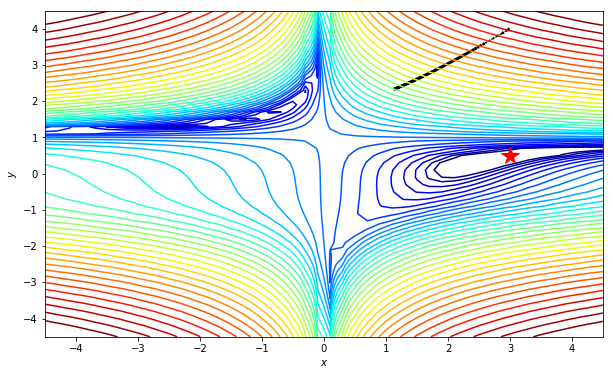

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*minima, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
plt.show()

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=18)

line, = ax.plot([], [], 'b', label='amsgrad', lw=2)
point, = ax.plot([], [], 'bo')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.legend(loc='upper left')

In [17]:
def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

In [18]:
def animate(i):
    line.set_data(*path[::,:i])
    point.set_data(*path[::,i-1:i])
    return line, point

In [19]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=path.shape[1], interval=60, 
                               repeat_delay=5, blit=True)

In [20]:
HTML(anim.to_html5_video())

In [21]:
fig_3d = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima, f(*minima), 'r*', markersize=10)

line_3d, = ax.plot([], [], [], 'b', label='Newton-CG', lw=2)
point_3d, = ax.plot([], [], [], 'bo')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

(-4.5, 4.5)

In [22]:
def init_3d():
    line_3d.set_data([], [])
    line_3d.set_3d_properties([])
    point_3d.set_data([], [])
    point_3d.set_3d_properties([])
    return line, point

In [23]:
def animate_3d(i):
    line_3d.set_data(path[0,:i], path[1,:i])
    line_3d.set_3d_properties(f(*path[::,:i]))
    point_3d.set_data(path[0,i-1:i], path[1,i-1:i])
    point_3d.set_3d_properties(f(*path[::,i-1:i]))
    return line, point

In [24]:
anim = animation.FuncAnimation(fig_3d, animate_3d, init_func=init_3d,
                               frames=path.shape[1], interval=60, 
                               repeat_delay=5, blit=True)

In [25]:
HTML(anim.to_html5_video())

In [26]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

In [27]:
class TrajectoryAnimation3D(animation.FuncAnimation):
    
    def __init__(self, *paths, zpaths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths
        self.zpaths = zpaths
        
        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]

        super(TrajectoryAnimation3D, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines

    def animate(self, i):
        for line, path, zpath in zip(self.lines, self.paths, self.zpaths):
            line.set_data(*path[::,:i])
            line.set_3d_properties(zpath[:i])
        return self.lines

In [28]:
# Beale's function
f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

xmin, xmax, xstep = -4.5, 4.5, .2
ymin, ymax, ystep = -4.5, 4.5, .2

x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

def getMinima(x,y):
    minima = np.array([float(x),float(y)])
    minima = minima.reshape(-1,1)
    return minima


x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = f(x,y)

In [29]:
from amsgrad import Amsgrad

x0 = np.array([-3., 4.])


algos = {}


w_adadelta = Variable(torch.FloatTensor(x0), requires_grad=True)
adadelta = torch.optim.Adadelta([w_adadelta])
algos['adadelta'] = [adadelta,beales_var,w_adadelta]

w_amsgrad = Variable(torch.FloatTensor(x0), requires_grad=True)
amsgrad = Amsgrad([w_amsgrad])
algos['amsgrad'] = [amsgrad,beales_var,w_amsgrad]

w_adagrad = Variable(torch.FloatTensor(x0), requires_grad=True)
adagrad = torch.optim.Adagrad([w_adagrad], lr=1)
algos['adagrad'] = [adagrad,beales_var,w_adagrad]

w_rmsprop = Variable(torch.FloatTensor(x0), requires_grad=True)
rmsprop = torch.optim.RMSprop([w_rmsprop])
algos['rmsprop'] = [rmsprop,beales_var,w_rmsprop]


sgd_lr = 1e-9

w_sgd = Variable(torch.FloatTensor(x0), requires_grad=True)
sgd = torch.optim.SGD([w_sgd], lr=sgd_lr)
algos['sgd'] = [sgd,beales_var,w_sgd]

w_sgdm = Variable(torch.FloatTensor(x0), requires_grad=True)
sgdm = torch.optim.SGD([w_sgdm], lr=1e-11, momentum=0.9)
algos['sgd_momentum'] = [sgdm,beales_var,w_sgdm]

w_nesterov = Variable(torch.FloatTensor(x0), requires_grad=True)
nesterov = torch.optim.SGD([w_nesterov], lr=sgd_lr, momentum=0.9, nesterov=True)
algos['sgd_nesterov'] = [nesterov,beales_var,w_nesterov]


w_adam = Variable(torch.FloatTensor(x0), requires_grad=True)
adam = torch.optim.Adam([w_adam], lr=0.01)
algos['adam'] = [adam,beales_var,w_adam]

In [30]:
paths = []
methods = []
zpaths = []

for key in algos.keys():
    path = optimize(algos[key][0],algos[key][1],algos[key][2],50000,400).T
    paths.append(path)
    zpaths.append(f(*path))
    methods.append(key)
    

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [32]:
HTML(anim.to_html5_video())

In [33]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima, f(*minima), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation3D(*paths, zpaths=zpaths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [34]:
HTML(anim.to_html5_video())

${\displaystyle f(x,y)=\sin ^{2}3\pi x+\left(x-1\right)^{2}\left(1+\sin ^{2}3\pi y\right)}
{\displaystyle +\left(y-1\right)^{2}\left(1+\sin ^{2}2\pi y\right)}$

In [35]:
# Rosenbrock Function

pi = np.pi
# Lévi function 
# f  = lambda x, y: (np.sin(3*pi*x))**2 + ((x-1)**2)*(1+np.sin(3*pi*y)**2)+((y-1)**2)*(1+np.sin(2*pi*y)**2)
f = lambda x,y: (1-x)**2 + 100*(y-x**2)**2
def f_var(var):
    x = var[0]
    y = var[1]
    return (1-x).pow(2) + 100*(y-x.pow(2)).pow(2)
#     return (3*pi*x).sin().pow(2) + ((x-1).pow(2))*(1+(3*pi*y).sin().pow(2))+((y-1).pow(2))*(1+(2*pi*y).sin().pow(2))

In [36]:
f(1,1)

0

In [37]:
xmin, xmax, xstep = -10, 10, .4
ymin, ymax, ystep = -10, 10, .4

In [38]:
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = f(x,y)

In [39]:
minima = getMinima(1,1)
f(1,1)

0

In [40]:
# rand = lambda : np.add(np.random.rand(1,2)*16,-8*np.ones((1,2)))[0]
rand = lambda : np.array([-4., 3.])

In [41]:
rand()[0]

-4.0

In [42]:
from amsgrad import Amsgrad

# x0 = np.array([-3., 4.])
x0 = np.array([-4., 3.])

algos = {}

w_amsgrad = Variable(torch.FloatTensor(rand()), requires_grad=True)
amsgrad = Amsgrad([w_amsgrad])
algos['amsgrad'] = [amsgrad,f_var,w_amsgrad]

w_adam = Variable(torch.FloatTensor(rand()), requires_grad=True)
adam = torch.optim.Adam([w_adam], lr=0.01)
algos['adam'] = [adam,f_var,w_adam]

w_adadelta = Variable(torch.FloatTensor(rand()), requires_grad=True)
adadelta = torch.optim.Adadelta([w_adadelta])
algos['adadelta'] = [adadelta,f_var,w_adadelta]

w_adagrad = Variable(torch.FloatTensor(rand()), requires_grad=True)
adagrad = torch.optim.Adagrad([w_adagrad], lr=1)
algos['adagrad'] = [adagrad,f_var,w_adagrad]

w_rmsprop = Variable(torch.FloatTensor(rand()), requires_grad=True)
rmsprop = torch.optim.RMSprop([w_rmsprop])
algos['rmsprop'] = [rmsprop,f_var,w_rmsprop]


sgd_lr = 1e-9

w_sgd = Variable(torch.FloatTensor(rand()), requires_grad=True)
sgd = torch.optim.SGD([w_sgd], lr=sgd_lr)
algos['sgd'] = [sgd,f_var,w_sgd]

w_sgdm = Variable(torch.FloatTensor(rand()), requires_grad=True)
sgdm = torch.optim.SGD([w_sgdm], lr=1e-11, momentum=0.9)
algos['sgd_momentum'] = [sgdm,f_var,w_sgdm]

w_nesterov = Variable(torch.FloatTensor(rand()), requires_grad=True)
nesterov = torch.optim.SGD([w_nesterov], lr=sgd_lr, momentum=0.9, nesterov=True)
algos['sgd_nesterov'] = [nesterov,f_var,w_nesterov]


In [43]:
paths = []
methods = []
zpaths = []

for key in algos.keys():
    path = optimize(algos[key][0],algos[key][1],algos[key][2],50000,100).T
    paths.append(path)
    zpaths.append(f(*path))
    methods.append(key)
    

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation(*paths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [45]:
HTML(anim.to_html5_video())

In [46]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima, f(*minima), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

anim = TrajectoryAnimation3D(*paths, zpaths=zpaths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [47]:
HTML(anim.to_html5_video())